# Cadenced Scheduling in Gurobi

<br>
This notebook will introduce you to a simple scheduling task in which you must determine the optimal means to monitor a list of targets. We will focus on the semester-scale 'top level' of the KPF scheduler, in which we require the cadenced monitoring of targets at or near a specified interval.

In [1]:
import gurobipy as gp
from gurobipy import GRB

# Create a new model
Mod = gp.Model("Cadenced Schedule")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-05


Given a list of $n$ targets denoted as $r \in R$ where $R = \{0,1,...,n-1\}$, with priorities $p_{r}$, we seek the optimal schedule to maximize the scientific ouput (observations * priority). Each target has a required interval $c_{r}$ after being observed that must pass before it may be targeted again.

In [2]:
#Set number of targets
n = 5

#Observational priorities
p = [1,2,3,3,2]

#Minimum separation (days)
c = [2,4,7,2,3]

#Identifiers for indexing
target_ids = range(n)

We can set up a simple framework of $m$ slots to schedule observations, denoted as $t \in T$, where $T = \{0,1,...,m-1\}$. Let's work with 50 consecutive days of observation, and suppose each day permits up to two observations. While simple, this can be easily generalized to larger problems. 

In [3]:
#Number of slots
m = 50

#Identifiers
slots = range(m)

Now we initialize some binary decision variables. Let's define $Y_{rt} = 1$ if target $r$ is successfully scheduled to slot $t$, and $Y_{rt} = 0$ otherwise. 

In [5]:
#Initialize multidimensional variables (matrices) by specifying the dimensions (x1,x2,..)
Y = Mod.addVars(target_ids, slots, vtype = GRB.BINARY, name = 'Y')

### Enforcing Cadenced Sampling
Turning our cadence minimums for each target into LP constraints requires that we enforce relationships between decision variables $Y$ evaluated at different times. For each target $r$, and each slot $t$, we define $T'_{r,t}$ to be the list of slots $\tau$, which are less than $c_{r}$ slots from $t$. In other words, $Y_{r,\tau}$ violates our cadence requirement, should $Y_{r,t}$ be scheduled.

We limit the scheduling of both variables using the expression:
<br>
<center>$1 - Y_{r,t} \ge Y_{r,\tau} \quad \forall \tau \in T'_{r,t}$</center>
<br>
This is the LP equivalent to a logical $\textit{or}$ constraint. Should $Y_{r,t}$ be scheduled (set to 1) the sum of the left hand side vanishes, forcing $Y_{r,\tau}$ to 0. If $Y_{r,t}$ is not scheduled, it forces no bounds on $Y_{r,\tau}$, which can take either value 0 or 1. Let's now construct $T'_{r,t}$.

In [6]:
from collections import defaultdict
import numpy as np

#Create a list of dictionaries for each target
#Each dictionary will map a date of observation to the inaccessible dates in T'
t_prime = []
for r in target_ids:
    targ_dict = defaultdict(list)
    min_sep = c[r]
    for t in slots:
        for tau in slots:
            if tau > t and np.abs(tau - t) < min_sep:
                targ_dict[t].append(tau)
    t_prime.append(targ_dict)

### Constraints
Now we can enforce the constraints that define our formulation. We want to limit the number of observations that can be scheduled per day to two, and enforce our minimum cadence requirement.

In [7]:
#Two per slot (night)
constr_two_targs = Mod.addConstrs((Y.sum('*',t) <= 2 for t in slots), 'constr_two_targs')

#Prevent scheduling to slots in T' for each target
for r in target_ids:
    for t in slots:
        #Retrieve marked slots, and constrain each
        invalid_slots = t_prime[r][t]
        Mod.addConstrs((1 - Y[r,t] >= Y[r,tau] for tau in invalid_slots),
                       'constr_cadence_{}_{}'.format(r,t))

### Objective
Now we need to set the objective. We'll assume our goal is to maximize the number of observed targets times their respective priorities, and calculate the schedule.

In [8]:
#Assign objective function: maximize priority times observations
Mod.setObjective(gp.quicksum(p[r]*Y[r,t] for r in target_ids for t in slots), GRB.MAXIMIZE)

Mod.update()
Mod.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 668 rows, 250 columns and 1486 nonzeros
Model fingerprint: 0x30a791a9
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 171.0000000
Presolve removed 381 rows and 0 columns
Presolve time: 0.01s
Presolved: 287 rows, 250 columns, 1086 nonzeros
Variable types: 0 continuous, 250 integer (250 binary)
Found heuristic solution: objective 172.0000000

Root relaxation: objective 1.808571e+02, 558 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  180.85714    0  106  172.00000  180.85714  5.

### Gurobi Output
After our time limit ends, the optimization will halt. The best possible solution found will be assigned to the model variable at that time. Let's examine the ouput in detail, line by line.

- The first two lines specify the version of Gurobi used to optimize the model, and the number of threads utilized by the solver/in your machine. If you've made any changes to the parameters that control the solver, they will appear here. Gurobipy allows you to access and alter these parameters through the API as well, see https://www.gurobi.com/documentation/10.0/refman/parameters.html
- Line three details the model shape that has been built using Gurobipy. The number of columns is equal to the number of variables (here the total size of $Y$). The number of rows in your model corresponds to the number of constraints that have been added. The coefficients of variable indeces in each constraint form the total constraint matrix, often called $A$. For most constraints, only a few variables are involved, so $A$ is almost always sparse. The LP problem then takes the form $Ax \le b$, where $x$ is a flattened vector of $Y$, and $b$ is specified row by row by our constraints.
- The next line specifies the types of variables within the model (Binary, Continuous, or Integer)
- Line five gives numerical data on the constraint matrix (ranges of coefficients and objective bounds)
- The next section details the presolve process executed by the optimizer. The presolve process takes the current model, and if possible, will reduce it to a smaller model before executing the full simplex algorithm. 
- Next is a brief message detailing that a maximal upper bound on the objective has been found using the simplex solver (this is done quickly for most models). This is found by first assuming that the variables can all take continuous values, then 'relaxing' to the nearest solution that satisfies your variable bounds (binary in this case). This relaxation is detailed in the next section.
- The largest section is the logging for the 'branch and cut' search for the optimal solution of the objective. The solver evaluates different paths along each dimension and finds what variable assignments maximize the objective. Columns printed in this step provide detailed information about the solving progress. Important takeaways are the Incumbent and BestBd columns. The Incumbent column gives the objective of the current solution that satisfies the variable bounds. The BestBd is the highest possible objective of all solutions remaining in the 'tree' of remaining possibilities. When these objectives become equal, optimality has been achieved and solving terminates.
- The remaining lines detail solution statistics. This includes the number of solutions found and their relative objectives. The final line tells us how close our objective was to the highest possible (since we reached optimality, these are equal).

In [9]:
#Query the solved parameters
scheduled_targets = defaultdict(list)
for v in Y.values():
    
    #Values retrieved from Model object often encounter precision, round to integer
    if np.round(v.X,0) == 1:
        indeces = v.VarName[2:][:-1].split(',')
        
        #Keys are dates/slots, values are targets assigned to that key
        scheduled_targets[int(indeces[1])].append(int(indeces[0]))

Now, we can plot our results based upon the slots assigned by the optimization. Each day will be filled with colors corresponding to the observed targets' indeces. This makes it easy to visualize how closely targets are being observed to their minimum desired cadence.

Text(0.5, 1.0, 'Visualizing 50 Days of Scheduling')

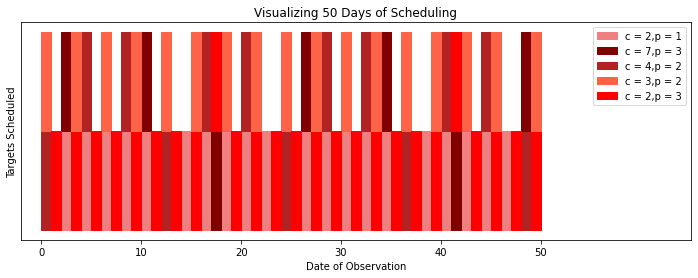

In [10]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,figsize=(12,4))
axs.set_xlim(-2,65)

#Unique colors for each target
target_colors = ['lightcoral','firebrick','maroon','red','tomato']

for day in scheduled_targets.keys():
    axs.fill_between([day,day+1],0,.5,color=target_colors[scheduled_targets[day][0]],
                     label='c = {},p = {}'.format(c[scheduled_targets[day][0]],p[scheduled_targets[day][0]]))
    if len(scheduled_targets[day]) == 2:
        axs.fill_between([day,day+1],.5,1,color=target_colors[scheduled_targets[day][1]],
                        label='c = {},p = {}'.format(c[scheduled_targets[day][1]],p[scheduled_targets[day][1]]))
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

axs.set_yticks([])
axs.set_xticks([0,10,20,30,40,50])
axs.set_xlabel('Date of Observation')
axs.set_ylabel('Targets Scheduled')
axs.set_title('Visualizing 50 Days of Scheduling')